    1. 'day'    = integer value of day number, starting at day = 0 for parameter day0, and incrementing by calendar day number (not by transaction day number)... 
                    Thus, 'day' may not include all possible integers from start to finish.  It only assigns integer values (based on the calendar) to days when 
                    there are transactions in the input dataframe --> if the input dataframe has no transactions on a particular day, that day's 'calendar' integer value will not be present in the column (will be = 0)
                    day_of_week = by name, Sunday, Monday, ...
                    day_of_month = 1-31
    2. 'week'   = integer value of week number, with week = 0 at time= parameter day0.  However, unlike 'day', the 'week' number is aligned not to start at day0, but rather
                    so that there is a full 'week' of 7 days that ends on Oct. 31, 2015 (the final day of training data).  This results in week = 0 having only 5 days in it.
                    n.b., the final week of October, 2015 is assigned 'week' number = 147.  week = 0 includes day0.  artifically assigning test to Nov. 30, 2015 results in test week = 152 (including only Nov 29 and 30)
    3. 'month'  = renamed "date_block_num" from original data set; no changes made.  Integer values from 0 to 33 represent the months starting at day0.  month=34 is Nov. 2015, and is the test month.
    4. 'quarter' = integer number of 3-month chunks of time, aligned with the end of October, 2015.  day0 is included in 'quarter' = 0, but 'quarter'=0 only contains 1 month (Jan 2013) of data due to the alignment
                    The months of August, Sept, Oct 2015 form 'quarter' = 11.  "Quarter" in this sense is just 3-month chunks... it is not the traditional Q1,Q2,Q3,Q4 beginning Jan 1, but instead is more like
                    date_block_num in that it is monotonically increasing integers, incremented every 3 months such that #11 ends at the end of our training data
    5. 'season' = integer number of 3-month chunks of time, reset each year (allowed values = 0,1,2,3)... not quite the same as spring-summer-winter-fall, or Q1,Q2,Q3,Q4, but instead shifted to 
                    better capture seasonal spending trends aligned in particular with high December spending
                    0 = Dec 1 to Feb 28 (biggest spending season), 1 = Mar 1 to May 31, 2 = June 1 to Aug 30 (lowest spending season), 3 = Sept 1 to Nov 30

#**Create Values for "daily" and/or "monthly" Weighting of Sales**
Also include some extra potential features like "month of year", "quarter", "season", "day of week" (Sun, Mon, Tues,...)
</br>

**Weighting options include:**
1. Normalizing the number of days in a month to equal November, 2015 test month
2. Normalizing the number of relative weekday sales to be equal to November, 2015:
  * Sat-Sun-Fri tend to have significantly more sales than other weekdays
  * Do this for units sold and also for revenue (better coupling with retail sales index)
3. Normalizing by the statistics for Russia's retail sales ( MoM retail sales data at https://tradingeconomics.com/russia/retail-sales ), to help take into account the depression/recession in 2015
4. Normalizing by "season", where "season" is 3-month chunks, non-traditionally aligned with sales trends to group spikes and depressions in sales:  
  * 2 = Dec 1 to Feb 28 (biggest spending season), 
  * 3 = Mar 1 to May 31, 
  * 0 = June 1 to Aug 30 (lowest spending season), 
  * 1 = Sept 1 to Nov 30
5. Normalizing by "quarter", where "quarter" is 3-month chunks, non-traditionally aligned with the end of training data (Oct. 31, 2015), and is not reset each year (i.e., it is monotonically increasing throughout the train set, just like "date_block_num"):
  * 0 = only the month of January, 2013 (due to the offset to end a quarter at end of train data)
  * 1 = Feb, Mar, Apr 2013
  * ...
  * 11 = Aug, Sept, Oct 2015
  * 12 = test month only, Nov 2015
6. Normalizing by month of the year (Jan, Feb, Mar...)
7. Do the above, but also include grouping by shop_federal_district


In [42]:
# python libraries/modules and some useful "constants" used in this notebook (with some holdovers from other, similar notebooks)
import pandas as pd
pd.set_option("display.max_rows",120)     # Override pandas choice of how many rows to show, so, for example, we can see the full 84-row item_category dataframe instead of the first few rows, then ...., then the last few rows
pd.set_option("display.max_columns",26)   # Similar to row code above, we can show more columns than default  
pd.set_option("display.width", 230)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, the drawback is that we will get output text wrapping)
pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)

import matplotlib.pyplot as plt
%matplotlib inline  
pltcolors = ['blue','red','green','black','darkorange','fuchsia','teal','gold','violet','olive','firebrick','gray','cyan','sienna','dodgerblue','lime','darkorchid','deeppink','turquoise','tan']

import numpy as np
import os

import datetime
from time import localtime, strftime, tzset, strptime
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()

import sklearn
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler  #, StandardScaler, RobustScaler

print(f'\nDone: {strftime("%a %X %x")}')


Done: Wed 08:32:15 06/03/20


In [43]:
''' ############################################################ '''
# Replace this path with the path on *your* Google Drive where the repo master branch is stored
#
GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
#
''' ############################################################ '''


# List of the data files (path relative to GitHub master), to be loaded into pandas DataFrames:              
data_files = [  #"readonly/final_project_data/shops.csv",
                #"data_output/shops_transl.csv",
                "data_output/shops_augmented.csv",
                "data_output/shops_new.csv",
               
                #"readonly/final_project_data/items.csv",
                #"data_output/items_transl.csv",
                "data_output/items_augmented.csv",
                "data_output/items_new.csv",
                #"data_output/items_clustered_22170.csv.gz",
               
                #"readonly/final_project_data/item_categories.csv",
                #"data_output/item_categories_transl.csv",
                "data_output/item_categories_augmented.csv",
               
                "readonly/final_project_data/sales_train.csv.gz",
                #"data_output/sales_train_cleaned.csv.gz",
               
                "readonly/final_project_data/test.csv.gz"
                ]

print(f'\nDone: {strftime("%a %X %x")}')


Done: Wed 08:32:16 06/03/20


In [44]:
# click on the URL link presented to you by this command, get your authorization code from Google, then paste it into the input box and hit 'enter' to complete mounting of the drive
from google.colab import drive  
drive.mount('/content/drive')

print(f'\nDone: {strftime("%a %X %x")}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Done: Wed 08:32:16 06/03/20


In [45]:
print('\n\ncsv files source directory: ', end='')
%cd "{GDRIVE_REPO_PATH}"
print("\nLoading csv Files from Google Drive repo into Colab...\n")

# Loop to load the data files into appropriately-named pandas DataFrames
for path_name in data_files:
    filename = path_name.rsplit("/")[-1]
    data_frame_name = filename.split(".")[0]
    exec(data_frame_name + " = pd.read_csv(path_name)")
    print(f'DataFrame {data_frame_name}, shape = {eval(data_frame_name).shape} :')
    print(eval(data_frame_name).head(2))
    print("\n")
    
print(f'done: {strftime("%a %X %x")}')



csv files source directory: /content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag

Loading csv Files from Google Drive repo into Colab...

DataFrame shops_augmented, shape = (60, 8) :
                       shop_name  shop_id                       en_shop_name shop_city shop_category shop_federal_district  shop_city_population  shop_tested
0  !Якутск Орджоникидзе, 56 фран        0  ! Yakutsk Ordzhonikidze, 56 Franc   Yakutsk          Shop               Eastern                235600        False
1  !Якутск ТЦ "Центральный" фран        1       ! Yakutsk TC "Central" Franc   Yakutsk          Mall               Eastern                235600        False


DataFrame shops_new, shape = (60, 14) :
   shop_id  shop_tested shop_type  shop_type_enc shop_city  shop_city_enc shop_federal_district  shop_federal_district_enc s_type_broad  s_type_broad_enc fd_popdens  fd_popdens_enc        fd_gdp  fd_gdp_enc
0        0        False      Shop             20   Yakutsk            

In [46]:
# remove outlier rows from training set
sales_train_cleaned0 = sales_train.copy(deep=True)
print(f'Len sales_train = {len(sales_train_cleaned0):,d}')
print('Rows being deleted:')
for i in [2909818,2909401,2326930,2257299,1163158,484683]:
    print(sales_train_cleaned0[sales_train_cleaned0.index == i])
    sales_train_cleaned0.drop(sales_train_cleaned0.index[i],inplace=True)
print(f'Len sales_train_cleaned0 (after outliers removed): {len(sales_train_cleaned0):,d}')

# merge together shops that seem to belong together:
sales_train_cleaned0['shop_id'] = sales_train_cleaned0.shop_id.apply(lambda x: 57 if x == 0 else x)
sales_train_cleaned0['shop_id'] = sales_train_cleaned0.shop_id.apply(lambda x: 58 if x == 1 else x)
sales_train_cleaned0['shop_id'] = sales_train_cleaned0.shop_id.apply(lambda x: 10 if x == 11 else x)
print(f'Len sales_train_cleaned0 (after shops 0, 1, 11 merged): {len(sales_train_cleaned0):,d}')

# for now, do not delete any shops
# print(sales_train_cleaned0.shop_id.nunique())
# sales_train_cleaned0 = sales_train_cleaned0[sales_train_cleaned0.shop_id != 9]
# print(len(sales_train_cleaned0))
# sales_train_cleaned0 = sales_train_cleaned0[sales_train_cleaned0.shop_id != 13]
# print(len(sales_train_cleaned0))

# create a revenue column ( = item_cnt_day * item_price)
sales_train_cleaned0['revenue'] = sales_train_cleaned0.item_cnt_day * sales_train_cleaned0.item_price
sales_train_cleaned0 = sales_train_cleaned0.astype({'date_block_num':np.int8,'shop_id':np.int8,'item_id':np.int16,
                            'item_price':np.float32,'item_cnt_day':np.int16,'revenue':np.int32}).reset_index(drop=True)
# merge with test dataframe
test['date_block_num'] = 34
test['date'] = '30.11.2015' #pd.Timestamp(year=2015, month=11, day=30)
sales_train_cleaned0 = sales_train_cleaned0.append(test)

# merge dataframes so we can do closer analysis of item dependence on shop and categories
sales_mrg = sales_train_cleaned0.merge(items_augmented[['item_id','item_category_id','item_tested','item_name']],on='item_id',how='left').reset_index(drop=True)
sales_mrg = sales_mrg.merge(item_categories_augmented[['item_category_id','en_cat_name','item_cat_tested']],on='item_category_id',how='left').reset_index(drop=True)
sales_mrg = sales_mrg.merge(shops_augmented[['shop_id', 'shop_tested', 'en_shop_name', 'shop_federal_district']], on='shop_id',how='left').reset_index(drop=True)
sales_mrg = sales_mrg[['date', 'item_price', 'item_cnt_day', 'revenue', 'item_id', 'item_tested', 'item_name', 'item_category_id',
                       'item_cat_tested', 'en_cat_name', 'shop_id', 'shop_tested', 'en_shop_name', 'shop_federal_district']]  # drop 'month' here... will be included when we merge with time_period dataframe
sales_mrg.columns = ['date', 'price', 'sales', 'revenue', 'item_id', 'i_test', 'item_name', 'i_cat_id', 'icat_test', 
                     'item_category_name', 'shop_id', 's_test', 'shop_name', 'district']

sales_mrg.insert(1,'day',0)
sales_mrg.date =  pd.to_datetime(sales_mrg.date, dayfirst=True)
sales_mrg.day = sales_mrg.date.apply(lambda x: (x - day0).days)
sales_mrg.drop('date',axis=1,inplace=True)
print('\n',sales_mrg.shape)
print(sales_mrg.head(),'\n')
print(sales_mrg.tail(),'\n')
print(f'sales_mrg dataframe creation done: {strftime("%a %X %x")}\n')

Len sales_train = 2,935,849
Rows being deleted:
               date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2909818  28.10.2015              33       12    11373       0.909          2169
               date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2909401  14.10.2015              33       12    20949           4           500
               date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2326930  15.01.2015              24       12    20949           4          1000
               date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2257299  19.12.2014              23       12    20949           4           500
               date  date_block_num  shop_id  item_id  item_price  item_cnt_day
1163158  13.12.2013              11       12     6066      307980             1
              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973          -1         

In [47]:
# create dataframe with day of week as text
day0 = datetime.datetime(2013,1,1)
ndays = (datetime.datetime(2015,12,1)-day0).days # = 1064
daynum = list(range(ndays))

delta = day0
month_count = 0
year = [delta.year]
month = [month_count]
month_of_year = [delta.month]
day_of_month = [delta.day]
day_of_week = [delta.strftime('%a')]  # use %A for full day name (not abbreviated)

for d in daynum[1:]:
    delta = day0 + datetime.timedelta(days=d)
    year.append(delta.year)
    if delta.month != month_of_year[-1]:
        month_count += 1
    month.append(month_count)
    month_of_year.append(delta.month)
    day_of_month.append(delta.day)
    day_of_week.append(delta.strftime('%a'))

time_periods = pd.DataFrame({'year':year, 'month':month, 'MoY':month_of_year,'day':daynum,'DoM':day_of_month,'DoW':day_of_week})   

time_periods.insert(1,'season',0)  
time_periods.season = (time_periods.month + 2) % 4

# sales_time = time_periods.copy(deep=True)
# for dayname in ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']:
#     sales_time[dayname+'s_in_M'] = sales_time.day_of_week.apply(lambda x: 1 if x == dayname else 0)

print(time_periods.shape)
print(time_periods.head(),'\n')
print(time_periods.tail())
print(f'\ntime_periods dataframe creation done: {strftime("%a %X %x")}\n')

(1064, 7)
   year  season  month  MoY  day  DoM  DoW
0  2013       2      0    1    0    1  Tue
1  2013       2      0    1    1    2  Wed
2  2013       2      0    1    2    3  Thu
3  2013       2      0    1    3    4  Fri
4  2013       2      0    1    4    5  Sat 

      year  season  month  MoY   day  DoM  DoW
1059  2015       0     34   11  1059   26  Thu
1060  2015       0     34   11  1060   27  Fri
1061  2015       0     34   11  1061   28  Sat
1062  2015       0     34   11  1062   29  Sun
1063  2015       0     34   11  1063   30  Mon

time_periods dataframe creation done: Wed 08:33:16 06/03/20



In [71]:
#df = time_periods[['month','DoW']].groupby('month').apply(pd.Series.value_counts) #, axis=0)
#df = time_periods.apply(pd.Series.value_counts,axis=0)
#df = time_periods.pivot(index='month', columns='DoW', values
df = time_periods.groupby('month').DoW.value_counts().to_frame().rename(columns={'DoW':'ndays'}).reset_index() #drop=True)
df

,month,DoW,ndays
0,0,Thu,5
1,0,Tue,5
2,0,Wed,5
3,0,Fri,4
4,0,Mon,4
...,...,...,...
240,34,Fri,4
241,34,Sat,4
242,34,Thu,4
243,34,Tue,4


In [51]:
# merge the dataframes to create a time-friendly version of sales info
sales_time = sales_mrg.merge(time_periods,on='day',how='outer')

# format to print better without wrapping:
sales_time.item_name = sales_time.item_name.apply(lambda x: str(x)[:30])
sales_time.item_category_name = sales_time.item_category_name.apply(lambda x: str(x)[:20])
sales_time.shop_name = sales_time.shop_name.apply(lambda x: str(x)[:15])
# note that the train dataset is sorted by month, but nothing obvious within the month; we sort it here for consistent results in calculations below
sales_time = sales_time.sort_values(['day','shop_id','item_id']).reset_index(drop=True)  

# combine shop federal districts based on behavior:
# mega-sales: Central
# spiky sales: None (online) --> "Online"
# only small spike at xmas: South
# average-looking: Volga Siberian Northwestern Ural Eastern --> "Typical"
district_change_dict = {'Central':'central','None':'online', 'South':'south', 'Volga':'typical', 'Northwestern':'typical', 'Siberian':'typical', 'Ural':'typical', 'Eastern':'typical', 'nan':np.NaN}
sales_time.district = sales_time.district.apply(lambda x: district_change_dict[str(x)] )

print(sales_time.shape)
print(sales_time.head())
print(sales_time.tail())

(3150072, 20)
   day  price  sales  revenue  item_id i_test                       item_name  i_cat_id icat_test    item_category_name  shop_id s_test        shop_name district  year  season  month  MoY  DoM  DoW
0    0     99      1       99      991  False  3d action puzzle dinosaur tyra        67      True   Gifts - Development        2   True  Adygea TC "Mega    south  2013       2      0    1    1  Tue
1    0   2599      1     2599     1472  False  assassin creed 3 xbox 360 russ        23      True      Games - XBOX 360        2   True  Adygea TC "Mega    south  2013       2      0    1    1  Tue
2    0    249      1      249     1905   True  bestseller grand theft auto sa        30      True  Games PC - Standard         2   True  Adygea TC "Mega    south  2013       2      0    1    1  Tue
3    0    599      2     1198     2920  False  disney lego pirate of caribbea        21      True           Games - PSP        2   True  Adygea TC "Mega    south  2013       2      0    1    1  

In [52]:
print(sales_time.season.unique())
print(sales_time.district.unique())
print(sales_time.DoW.unique())

[2 3 0 1]
['south' 'central' 'typical' 'online' nan]
['Tue' 'Wed' 'Thu' 'Fri' 'Sat' 'Sun' 'Mon']


In [0]:
# group by month and district, with separate columns for each DoW day of the week

sales_time = time_periods.copy(deep=True)
for dayname in ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']:
    sales_time[dayname+'s_in_M'] = sales_time.day_of_week.apply(lambda x: 1 if x == dayname else 0)

In [15]:
# count number of days in each month, including how many of each day (Sun, Mon, ...), then save as a csv file



days_by_month = days_by_month.groupby('month').agg({'year':'mean', 'month_of_year':'mean', 'day':'count',
                                      'Sundays_in_month':'sum', 'Mondays_in_month':'sum', 'Tuesdays_in_month':'sum', 
                                      'Wednesdays_in_month':'sum', 'Thursdays_in_month':'sum', 'Fridays_in_month':'sum', 
                                      'Saturdays_in_month':'sum'}).reset_index().rename(columns={'day':'days_in_month'})



# Weighting the sales by number of days in a month, and number of each weekday in a month (more sales happen on Fri-Sun-Sat)
#     note:  holidays are difficult to categorize in terms of their effect on sales; will just leave them out for now
# 
# from another notebook, I grouped by month, and these are the quantiles for sales on each of the days (for each of the 34 months):
#        month     Sunday     Monday    Tuesday  Wednesday   Thursday     Friday   Saturday
# count     34         34         34         34         34         34         34         34
# mean  16.500 17,920.412 11,808.441 13,381.912 12,854.235 13,341.853 16,263.353 21,607.294
# std    9.958  6,004.235  4,046.100  4,313.225  3,890.887  3,461.607  4,503.688  6,889.363
# min        0       8231       5431       7161       6779       7109       8782       9914
# 25%    8.250 13,340.500  9,343.750 10,535.500 10,624.500 10,508.250 12,714.250 16,706.500
# 50%   16.500      17575      11568      13128 11,830.500      13515      16656      20853
# 75%   24.750 21,551.750 13,014.750      14657      14789      15576 19,644.500      26414
# max       33      36975      26721      26877      26003      19662      25504      36028

# Let's weight the sales by the mean sale of each day x number of those days in each month, all relative to month = 34 (= test month, November 2015)
days_by_month['sales_weight'] = (days_by_month.Sundays_in_month * 17920 + days_by_month.Mondays_in_month * 11808 + days_by_month.Tuesdays_in_month * 13382 + days_by_month.Wednesdays_in_month * 12854 + 
                                 days_by_month.Thursdays_in_month * 13342 + days_by_month.Fridays_in_month * 16263 + days_by_month.Saturdays_in_month * 21607)

# normalize to test month (Nov 2015) such that if one uses this column, one should multiply every month's sales by this amount
testweight = days_by_month.at[34,'sales_weight2']
days_by_month.sales_weight2 = round(days_by_month.sales_weight2 / testweight, 3)

# now let's take into account the depression in Russia's economy in 2015
#  using MoM retail sales data at https://tradingeconomics.com/russia/retail-sales
retail_pctchange_mo = [-1.8, 8.4, 0, 2.3, 1.7, 2.5, 2.6, -1.4, 2.3, 0.1, 19.4, -26.8, -0.5, 8.6, -1.4, 1.7, 0.6, 3.1, 3, -1.6, 2.2, 0.1, 23.2, -33.3, -3.7, 6.8, -2.4, 2.2, 0.4, 3.2, 3.1, -3, 1.6, -1]
retail_sales = [100]
for m in range(34):
    retail_sales.append(retail_sales[-1] + retail_sales[-1] * retail_pctchange_mo[m]/100)

days_by_month['retail_sales'] = retail_sales

print(days_by_month.shape)
print(days_by_month.head(),'\n')
print(days_by_month.tail())

(1064, 6)
   year  month_of_year  month  day  day_of_month day_of_week
0  2013              1      0    0             1     Tuesday
1  2013              1      0    1             2   Wednesday
2  2013              1      0    2             3    Thursday
3  2013              1      0    3             4      Friday
4  2013              1      0    4             5    Saturday 

      year  month_of_year  month   day  day_of_month day_of_week
1059  2015             11     34  1059            26    Thursday
1060  2015             11     34  1060            27      Friday
1061  2015             11     34  1061            28    Saturday
1062  2015             11     34  1062            29      Sunday
1063  2015             11     34  1063            30      Monday 


(35, 13)
   month  year  month_of_year  days_in_month  Sundays_in_month  Mondays_in_month  Tuesdays_in_month  Wednesdays_in_month  Thursdays_in_month  Fridays_in_month  Saturdays_in_month  sales_weight  retail_sales
0      0  201

In [0]:
df4 = tt[tt.month<34].groupby(['month','day_of_week']).agg({'sales':['sum']}).reset_index()
df4.columns = ['month','day_of_week','sales']
print(df4.head())
df4p = df4.pivot(index = 'month', columns = 'day_of_week', values = 'sales').reset_index()
df4p.columns = ['month','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
df4pcols = df4p.columns
print(df4p.head())
print(df4p.shape)
print(df4p.describe())

   month  day_of_week  sales
0      0            0  20717
1      0            1  13067
2      0            2  15399
3      0            3  20162
4      0            4  19662
   month  Sunday  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday
0      0   20717   13067    15399      20162     19662   18372     24100
1      1   22583   11971    14130      13842     15995   20523     29046
2      2   26756   12193    15751      15264     17667   25435     34076
3      3   18779   12858    14198      10596     12036   15501     23222
4      4   15740   10060    10486      16639     16296   20118     17630
(34, 8)
       month     Sunday     Monday    Tuesday  Wednesday   Thursday     Friday   Saturday
count     34         34         34         34         34         34         34         34
mean  16.500 17,920.412 11,808.441 13,381.912 12,854.235 13,341.853 16,263.353 21,607.294
std    9.958  6,004.235  4,046.100  4,313.225  3,890.887  3,461.607  4,503.688  6,889.363
min        0       8

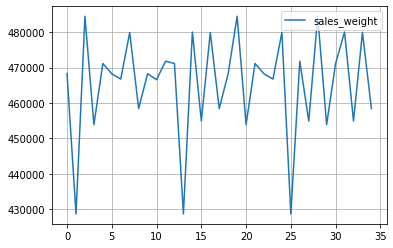

In [17]:
days_by_month.plot(y='sales_weight',kind='line',grid=True)
done=True

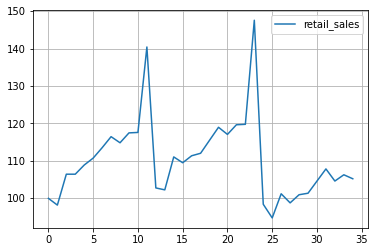

In [0]:
days_by_month.plot(y='retail_sales',kind='line',grid=True)
done=True

In [21]:

days_by_month['sales_weight2'] = 1e9/(days_by_month.sales_weight * days_by_month.retail_sales)

# normalize to month 34 ( = test month Nov 2015)
testweight = days_by_month.at[34,'sales_weight2']
days_by_month.sales_weight2 = round(days_by_month.sales_weight2 / testweight, 3)

print(days_by_month.shape)
print(days_by_month.head(),'\n')
print(days_by_month.tail())

(35, 14)
   month  year  month_of_year  days_in_month  Sundays_in_month  Mondays_in_month  Tuesdays_in_month  Wednesdays_in_month  Thursdays_in_month  Fridays_in_month  Saturdays_in_month  sales_weight  retail_sales  sales_weight2
0      0  2013              1             31                 4                 4                  5                    5                   5                 4                   4        468282           100            103
1      1  2013              2             28                 4                 4                  4                    4                   4                 4                   4        428704        98.200            115
2      2  2013              3             31                 5                 4                  4                    4                   4                 5                   5        484494       106.449             94
3      3  2013              4             30                 4                 5                  5    

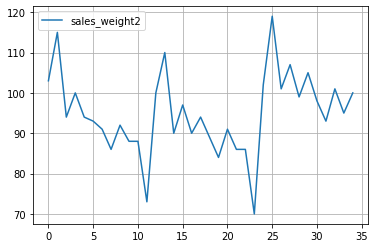

In [22]:
days_by_month.plot(y='sales_weight2',kind='line',grid=True)
done=True

In [23]:
# to normalize sales per month by number of days in month (28-31), divide by column "days_in_month"
# to normalize sales per month by number of days in month, number of each weekday (Sun, Mon, Tues...) in month (mean sales over all 34 train months), divide by column "sales_weight"
# to normalize sales per month by recorded retail sales per month numbers for Russia, divide by column "retail_sales"
# to normalize sales per month by number of days in month (28-31), number of each weekday (mean sales over all 34 train months), and retail sales numbers for Russia, MULTIPLY by column "sales_weight2"

GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
%cd "{GDRIVE_REPO_PATH}"

days_by_month.to_csv("data_output/days_by_month.csv", index=False)

/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag
